# Transit Desert Analysis: Baltimore City

Interactive exploration of transit desert analysis results.

**Run the pipeline first:** `python run_pipeline.py`

In [6]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

try:
    import folium
    FOLIUM_AVAILABLE = True
except ImportError:
    FOLIUM_AVAILABLE = False

plt.style.use('seaborn-v0_8-whitegrid')
PROJECT_ROOT = Path('.').parent if Path('.').name == 'notebooks' else Path('.')
DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
print(f"Data directory: {DATA_DIR.resolve()}")

Data directory: /Users/oluwasegunadegoke/Desktop/Projects/Identifying_Transit_Deserts/transit-desert-pipeline/notebooks/data/processed


In [11]:
# Use .resolve() or Path.cwd() to get the actual folder name
current_path = Path('.').resolve()

if current_path.name == 'notebooks':
    PROJECT_ROOT = current_path.parent
else:
    PROJECT_ROOT = current_path

DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
print(f"Corrected Data directory: {DATA_DIR}")

Corrected Data directory: /Users/oluwasegunadegoke/Desktop/Projects/Identifying_Transit_Deserts/transit-desert-pipeline/data/processed


## 1. Load Data

In [12]:
gdf = gpd.read_file(DATA_DIR.resolve() / 'transit_deserts.gpkg') 
print(f"Loaded {len(gdf)} Census tracts")
gdf[['CPTA_normalized', 'TDI_normalized', 'transit_gap', 'classification_simple']].head(10)

Loaded 408 Census tracts


,CPTA_normalized,TDI_normalized,transit_gap,classification_simple
0,37.508086,43.065230,5.557144,Underserved
1,40.696787,27.093996,-13.602790,Well-Served
2,36.104937,50.484595,14.379658,Transit Desert
3,35.126334,32.791486,-2.334848,Underserved
4,33.453571,77.692407,44.238837,Transit Desert
5,47.142912,53.018159,5.875246,Transit Stressed
6,44.003146,60.282851,16.279705,Transit Stressed
7,37.210784,36.951809,-0.258975,Underserved
8,34.671020,29.348810,-5.322210,Underserved
9,36.918754,56.586612,19.667858,Transit Desert


## 2. Classification Summary

In [13]:
print("Transit Desert Classification:")
print(gdf['classification_simple'].value_counts())
print(f"\nTotal Transit Deserts: {gdf['transit_desert'].sum()}")

Transit Desert Classification:
classification_simple
Underserved         130
Transit Stressed    130
Well-Served          74
Transit Desert       74
Name: count, dtype: int64

Total Transit Deserts: 128


## 3. Supply vs Demand Scatter

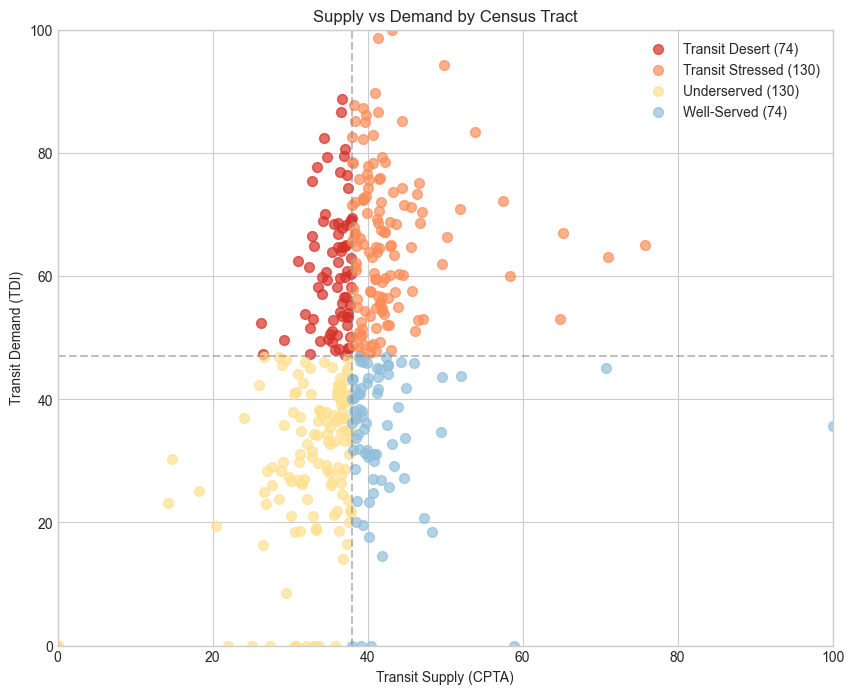

In [14]:
colors = {'Transit Desert': '#d73027', 'Transit Stressed': '#fc8d59', 
          'Underserved': '#fee090', 'Well-Served': '#91bfdb'}

fig, ax = plt.subplots(figsize=(10, 8))
for cat, color in colors.items():
    subset = gdf[gdf['classification_simple'] == cat]
    ax.scatter(subset['CPTA_normalized'], subset['TDI_normalized'], 
               c=color, label=f"{cat} ({len(subset)})", alpha=0.7, s=50)

ax.axvline(gdf['CPTA_normalized'].median(), color='gray', linestyle='--', alpha=0.5)
ax.axhline(gdf['TDI_normalized'].median(), color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Transit Supply (CPTA)')
ax.set_ylabel('Transit Demand (TDI)')
ax.set_title('Supply vs Demand by Census Tract')
ax.legend()
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
plt.show()

## 4. Maps

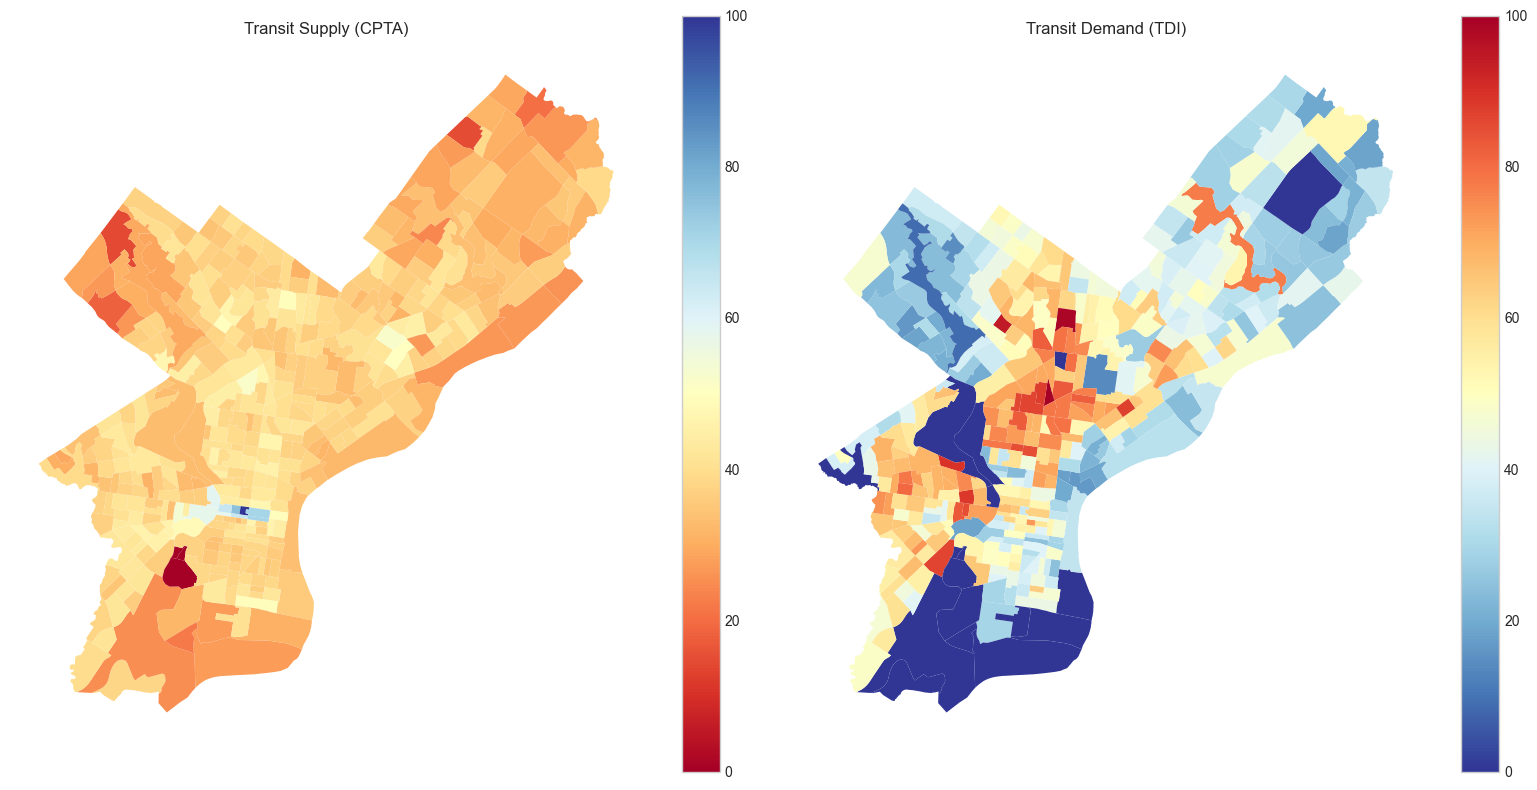

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(column='CPTA_normalized', cmap='RdYlBu', legend=True, ax=axes[0])
axes[0].set_title('Transit Supply (CPTA)')
axes[0].set_axis_off()

gdf.plot(column='TDI_normalized', cmap='RdYlBu_r', legend=True, ax=axes[1])
axes[1].set_title('Transit Demand (TDI)')
axes[1].set_axis_off()

plt.tight_layout()
plt.show()

/var/folders/g5/s9j4vt_n7k38gs24fcm_lpj40000gn/T/ipykernel_80916/1306407364.py:6: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
/var/folders/g5/s9j4vt_n7k38gs24fcm_lpj40000gn/T/ipykernel_80916/1306407364.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


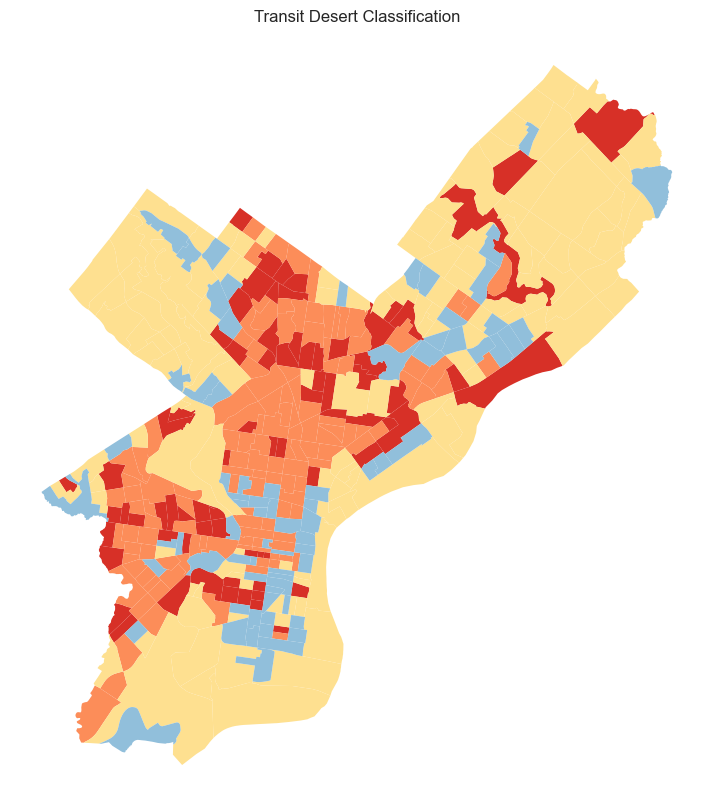

In [16]:
# Classification map
fig, ax = plt.subplots(figsize=(12, 10))
for cat, color in colors.items():
    gdf[gdf['classification_simple'] == cat].plot(color=color, ax=ax, label=cat)
ax.set_title('Transit Desert Classification')
ax.legend()
ax.set_axis_off()
plt.show()

## 5. Equity Analysis

In [17]:
deserts = gdf[gdf['transit_desert'] == True]
non_deserts = gdf[gdf['transit_desert'] == False]

metrics = ['pct_zero_vehicle', 'pct_poverty', 'pct_minority', 'pct_elderly']
comparison = pd.DataFrame({
    'Transit Deserts': [deserts[m].mean() for m in metrics],
    'Non-Deserts': [non_deserts[m].mean() for m in metrics]
}, index=['Zero-Vehicle HH', 'Below Poverty', 'Minority Pop', 'Elderly 65+'])

comparison['Difference'] = comparison['Transit Deserts'] - comparison['Non-Deserts']
print(comparison.round(3) * 100)

                 Transit Deserts  Non-Deserts  Difference
Zero-Vehicle HH             40.1         21.4        18.7
Below Poverty               33.7         15.5        18.2
Minority Pop                86.1         50.9        35.2
Elderly 65+                 14.3         13.8         0.5


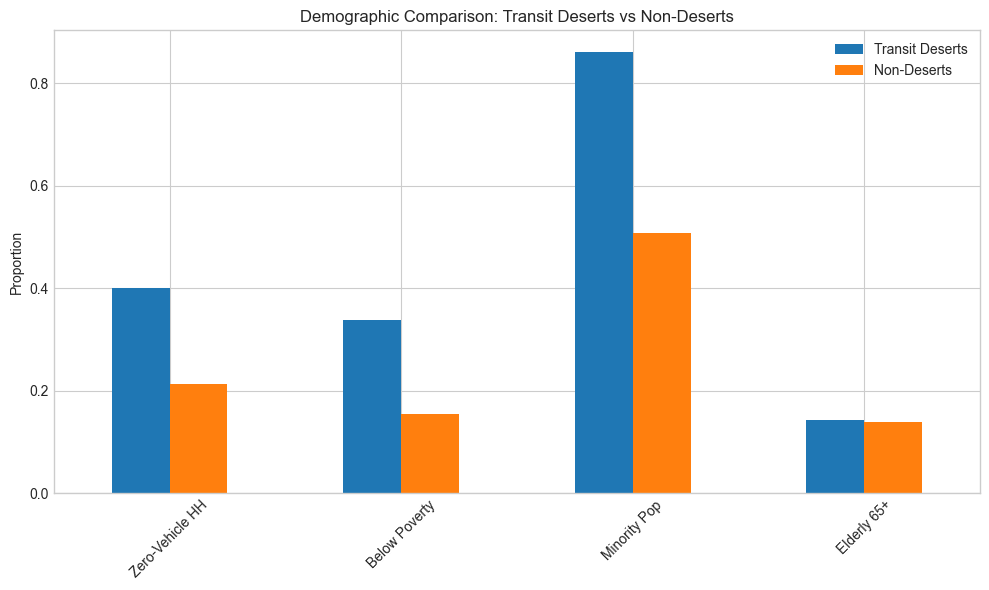

In [18]:
# Equity bar chart
comparison[['Transit Deserts', 'Non-Deserts']].plot(kind='bar', figsize=(10, 6))
plt.title('Demographic Comparison: Transit Deserts vs Non-Deserts')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 6. LISA Clusters

In [19]:
print("LISA Cluster Counts:")
print(gdf['lisa_cluster'].value_counts())

LISA Cluster Counts:
lisa_cluster
Not Significant    265
High-High           75
Low-Low             58
High-Low             5
Low-High             5
Name: count, dtype: int64


/var/folders/g5/s9j4vt_n7k38gs24fcm_lpj40000gn/T/ipykernel_80916/2742794918.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower right')
/var/folders/g5/s9j4vt_n7k38gs24fcm_lpj40000gn/T/ipykernel_80916/2742794918.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right')


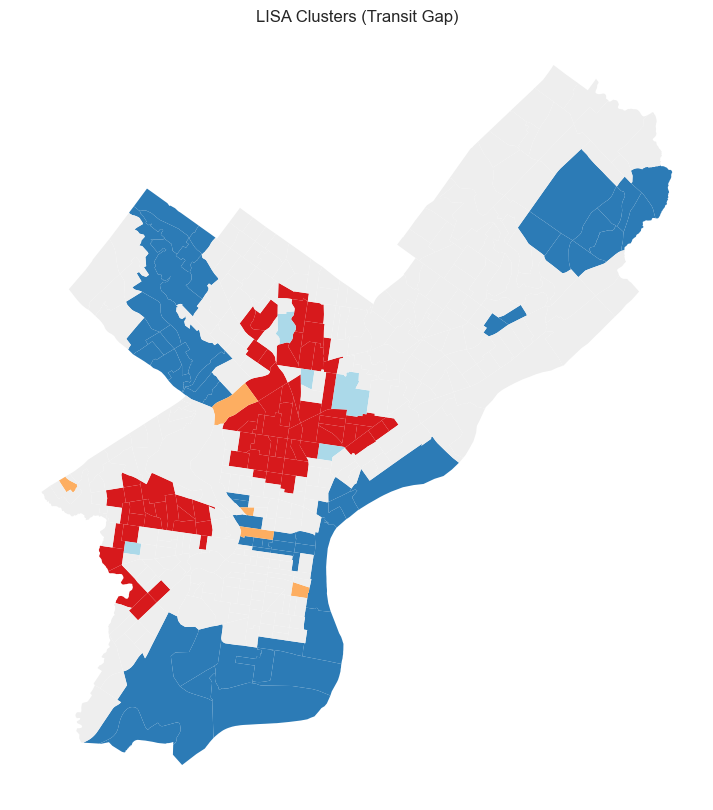

In [20]:
lisa_colors = {'High-High': '#d7191c', 'Low-Low': '#2c7bb6', 'High-Low': '#fdae61',
               'Low-High': '#abd9e9', 'Not Significant': '#eeeeee'}

fig, ax = plt.subplots(figsize=(12, 10))
for cluster, color in lisa_colors.items():
    subset = gdf[gdf['lisa_cluster'] == cluster]
    if len(subset) > 0:
        subset.plot(color=color, ax=ax, label=f"{cluster} ({len(subset)})")

ax.set_title('LISA Clusters (Transit Gap)')
ax.legend(loc='lower right')
ax.set_axis_off()
plt.show()

## 7. Interactive Map (Folium)

In [21]:
if FOLIUM_AVAILABLE:
    # Create interactive map
    gdf_wgs84 = gdf.to_crs('EPSG:4326')
    center = [gdf_wgs84.geometry.centroid.y.mean(), gdf_wgs84.geometry.centroid.x.mean()]
    
    m = folium.Map(location=center, zoom_start=11, tiles='CartoDB positron')
    
    # Add choropleth
    folium.Choropleth(
        geo_data=gdf_wgs84.__geo_interface__,
        data=gdf_wgs84,
        columns=['GEOID', 'transit_gap'],
        key_on='feature.properties.GEOID',
        fill_color='RdYlBu_r',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Transit Gap'
    ).add_to(m)
    
    display(m)
else:
    print("Install folium for interactive maps: pip install folium")

/var/folders/g5/s9j4vt_n7k38gs24fcm_lpj40000gn/T/ipykernel_80916/4091883790.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center = [gdf_wgs84.geometry.centroid.y.mean(), gdf_wgs84.geometry.centroid.x.mean()]


## 8. Export Results

In [22]:
# Export transit deserts to CSV
transit_deserts = gdf[gdf['transit_desert'] == True][['GEOID', 'TDI_normalized', 'CPTA_normalized', 'transit_gap', 'lisa_cluster']]
print(f"Transit Desert Tracts ({len(transit_deserts)}):")
transit_deserts.sort_values('transit_gap', ascending=False).head(10)

Transit Desert Tracts (128):


,GEOID,TDI_normalized,CPTA_normalized,transit_gap,lisa_cluster
181,42101028200,98.569234,41.276684,57.292550,High-High
44,42101020000,100.000000,43.193429,56.806571,High-High
154,42101009100,88.661392,36.699848,51.961544,High-High
142,42101039100,86.636214,36.539480,50.096734,Not Significant
102,42101020101,87.800645,38.229322,49.571324,High-High
179,42101028000,82.329026,34.411016,47.918010,High-High
69,42101018801,87.286641,39.389357,47.897284,High-High
120,42101014800,85.089173,38.302721,46.786452,High-High
265,42101017201,86.170918,39.841776,46.329142,High-High
119,42101014700,85.068363,39.714148,45.354215,High-High
